In [1]:

import statsmodels.api as sm
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedGroupKFold


import numpy as np
import pandas as pd
import sys

from polyssifier import poly

import logging 

import scipy.sparse as sp
import scipy.io
from scipy.stats import zscore
from scipy.signal import detrend

from scipy.sparse.linalg import eigs
from gunfolds.utils import graphkit as gk
from gunfolds.conversions import graph2adj

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state
from sklearn.impute import SimpleImputer


from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score

In [45]:
def check_matrix_powers(W, A, powers, threshold):
    for n in powers:
        W_n = np.linalg.matrix_power(W, n)
        non_zero_indices = np.nonzero(W_n)
        if (np.abs(W_n[non_zero_indices]) < threshold).any():
            return False
    return True


def create_stable_weighted_matrix(
    A,
    threshold=0.1,
    powers=[1, 2, 3, 4],
    max_attempts=1000,
    damping_factor=0.99,
    random_state=None,
):
    np.random.seed(
        random_state
    )  # Set random seed for reproducibility if provided
    attempts = 0

    while attempts < max_attempts:
        # Generate a random matrix with the same sparsity pattern as A
        random_weights = np.random.randn(*A.shape)
        weighted_matrix = A * random_weights

        # Convert to sparse format for efficient eigenvalue computation
        weighted_sparse = sp.csr_matrix(weighted_matrix)

        # Compute the largest eigenvalue in magnitude
        eigenvalues, _ = eigs(weighted_sparse, k=1, which="LM")
        max_eigenvalue = np.abs(eigenvalues[0])

        # Scale the matrix so that the spectral radius is slightly less than 1
        if max_eigenvalue > 0:
            weighted_matrix *= damping_factor / max_eigenvalue
            # Check if the powers of the matrix preserve the threshold for non-zero entries of A
            if check_matrix_powers(weighted_matrix, A, powers, threshold):
                return weighted_matrix

        attempts += 1

    raise ValueError(
        f"Unable to create a matrix satisfying the condition after {max_attempts} attempts."
    )


def drawsamplesLG(A, nstd, samples):
    n = A.shape[0]
    data = np.zeros([n, samples])
    data[:, 0] = nstd * np.random.randn(A.shape[0])
    for i in range(1, samples):
        data[:, i] = A @ data[:, i - 1] + nstd * np.random.randn(A.shape[0])
    return data


def genData(A, rate=2, burnin=100, ssize=5000, nstd=1):
    Agt = A.copy()
    data = drawsamplesLG(Agt, samples=burnin + (ssize * rate), nstd=nstd)
    data = data[:, burnin:]
    return data[:, ::rate]



In [46]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


nstd = 1.0
burn = 100
threshold = 0.0001

NOISE_SIZE = 1200
#subjects = np.loadtxt("/data/users2/jwardell1/undersampling-project/HCP/txt-files/subjects.txt", dtype=str)
subjects = np.loadtxt("/data/users2/jwardell1/undersampling-project/HCP/txt-files/subjects_dbg.txt", dtype=str)
NUM_SUBS = len(subjects)

num_graphs = 1
num_noise = 2
n_folds = 4
n_threads= 12

graph_ix = 1002
graph_dir = '/data/users2/jwardell1/nshor_docker/examples/hcp-project/HCP/g4.pkl'
g = np.load(graph_dir, allow_pickle=True)
A = graph2adj(g)
u_rate = 1
logging.info(f'\t\t\t\tGraph Number {graph_ix} of {num_graphs}')
logging.info(f'\t\t\t\tNUM_SUBS {NUM_SUBS}')

#SNR = 1

SNRs = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.5, 2.0]

2024-05-10 01:42:10,780 - INFO - 				Graph Number 1002 of 1
2024-05-10 01:42:10,781 - INFO - 				NUM_SUBS 10


In [47]:
num_converged = 0
converged_subjects = []
noises = dict()
while num_converged < NUM_SUBS:
    for subject in subjects:
        if subject in converged_subjects:
            continue

        try:
            W = create_stable_weighted_matrix(A, threshold=threshold, powers=[2])
            var_noise = genData(W, rate=u_rate, burnin=burn, ssize=NOISE_SIZE, nstd=nstd)
            var_noise = zscore(var_noise, axis=1)
            noises[subject] = var_noise 
            num_converged += 1
            converged_subjects.append(subject)

        except Exception as e:
            print(e)
            logging.info(f'num converged: {num_converged}')
            


2024-05-10 01:42:11,632 - INFO - num converged: 0


ARPACK error -1: No convergence (531 iterations, 0/1 eigenvectors converged) [ARPACK error -14: DNAUPD  did not find any eigenvalues to sufficient accuracy.]


2024-05-10 01:42:13,326 - INFO - num converged: 8


ARPACK error -1: No convergence (531 iterations, 0/1 eigenvectors converged) [ARPACK error -14: DNAUPD  did not find any eigenvalues to sufficient accuracy.]


In [48]:
all_data = []

#tc_filepath = '/data/users2/jwardell1/undersampling-project/HCP/txt-files/tc_data.txt'
tc_filepath = '/data/users2/jwardell1/undersampling-project/HCP/txt-files/tc_data_dbg.txt'
with open(tc_filepath, 'r') as tc_data:
    lines = tc_data.readlines()

for i in range(len(lines)):
    
    logging.info(f'loading TC for subject {subject}')
    filepath_sr1 = lines[i].strip()
    try:
        sr1_tc = scipy.io.loadmat(filepath_sr1)['TCMax']
    
    except:
        continue

    subject = filepath_sr1.split('/')[-3]

    if sr1_tc.shape[0] != 53:
        sr1_tc = sr1_tc.T

    if sr1_tc.shape[1] < 1200:
        continue

    logging.info(f'sr1.shape - {sr1_tc.shape}')
    sr1_tc_zc = zscore(sr1_tc, axis=1)
    sr1_tc_zc_dt = scipy.signal.detrend(sr1_tc_zc, axis=1)

    sr2_tc_zc_dt = sr1_tc_zc_dt[:,::3]
    logging.info(f'sr2.shape - {sr2_tc_zc_dt.shape}')


    noise_sr1 = noises[subject]
    noise_sr2 = noises[subject][:,::3]

    #sr1_tc_zs_dt_noise = sr1_tc_zs_dt+noise_sr1
    #sr2_tc_zs_dt_noise = sr2_tc_zs_dt+noise_sr2

    all_data.append({'Subject_ID'             : str(subject), 
                    'VAR_Noise'               : noises[subject], 
                    'SR1_Noise'               : noise_sr1, 
                    'SR2_Noise'               : noise_sr2, 
                    'SR1_Timecourse'          : sr1_tc_zc_dt, 
                    'SR2_Timecourse'          : sr2_tc_zc_dt, 
                    })
    
data_df = pd.DataFrame(all_data)

data_df

2024-05-10 01:42:13,511 - INFO - loading TC for subject 387959
2024-05-10 01:42:13,519 - INFO - sr1.shape - (53, 1200)
2024-05-10 01:42:13,540 - INFO - sr2.shape - (53, 400)
2024-05-10 01:42:13,541 - INFO - loading TC for subject 377451
2024-05-10 01:42:13,547 - INFO - sr1.shape - (53, 1200)
2024-05-10 01:42:13,551 - INFO - sr2.shape - (53, 400)
2024-05-10 01:42:13,552 - INFO - loading TC for subject 378857
2024-05-10 01:42:13,558 - INFO - sr1.shape - (53, 1200)
2024-05-10 01:42:13,563 - INFO - sr2.shape - (53, 400)
2024-05-10 01:42:13,564 - INFO - loading TC for subject 379657
2024-05-10 01:42:13,570 - INFO - sr1.shape - (53, 1200)
2024-05-10 01:42:13,574 - INFO - sr2.shape - (53, 400)
2024-05-10 01:42:13,575 - INFO - loading TC for subject 380036
2024-05-10 01:42:13,581 - INFO - sr1.shape - (53, 1200)
2024-05-10 01:42:13,584 - INFO - sr2.shape - (53, 400)
2024-05-10 01:42:13,585 - INFO - loading TC for subject 381038
2024-05-10 01:42:13,591 - INFO - sr1.shape - (53, 1200)
2024-05-10 

,Subject_ID,VAR_Noise,SR1_Noise,SR2_Noise,SR1_Timecourse,SR2_Timecourse
0,377451,"[[-0.33175890074299913, 0.8088308061148727, 0....","[[-0.33175890074299913, 0.8088308061148727, 0....","[[-0.33175890074299913, -1.7427093497512853, 0...","[[2.4401631689261625, 0.16598920567395492, 0.4...","[[2.4401631689261625, -0.6451096984904231, -1...."
1,378857,"[[0.9015964998489446, -0.41628727989126174, -0...","[[0.9015964998489446, -0.41628727989126174, -0...","[[0.9015964998489446, -1.7763694587632557, -0....","[[1.8867215094126368, 1.0806969036949567, 0.43...","[[1.8867215094126368, -0.2790259108692743, -0...."
2,379657,"[[0.7170012916674678, -0.47502742358980876, 0....","[[0.7170012916674678, -0.47502742358980876, 0....","[[0.7170012916674678, 0.14971959577380659, -0....","[[1.0349024010979477, -0.2431502435375532, -0....","[[1.0349024010979477, -0.6875192019184282, -0...."
3,380036,"[[0.9633443795014597, 0.7860439751557348, 0.78...","[[0.9633443795014597, 0.7860439751557348, 0.78...","[[0.9633443795014597, 0.6820655167549162, 1.84...","[[3.475910521978646, 1.371994896838827, 0.6443...","[[3.475910521978646, 0.2506660398416013, -0.69..."
4,381038,"[[-0.8328293602353821, -1.2998560849117637, -1...","[[-0.8328293602353821, -1.2998560849117637, -1...","[[-0.8328293602353821, -1.3562584509236133, -0...","[[4.213051196152492, 1.7180691482519028, 1.994...","[[4.213051196152492, 1.0008819286450896, 0.122..."
5,381543,"[[-0.49236258773795505, 0.5989036427339699, -0...","[[-0.49236258773795505, 0.5989036427339699, -0...","[[-0.49236258773795505, 0.7837373712386176, -0...","[[4.079893667797041, 1.145439952599419, -0.530...","[[4.079893667797041, -0.44821405602948333, -0...."
6,382242,"[[-0.5099712220957333, 0.43923963921156745, 0....","[[-0.5099712220957333, 0.43923963921156745, 0....","[[-0.5099712220957333, -1.1428658612865719, 0....","[[-0.6944408215653143, -0.3173594296841724, 0....","[[-0.6944408215653143, -0.7246317042244764, -0..."
7,385450,"[[1.2496246474925734, 0.052027911592087354, -0...","[[1.2496246474925734, 0.052027911592087354, -0...","[[1.2496246474925734, -1.4286137498923053, -1....","[[2.421128149739236, 1.285301756218307, -0.645...","[[2.421128149739236, -0.5184629856760293, -1.4..."
8,386250,"[[0.4003900892822189, -0.5770442141255616, -0....","[[0.4003900892822189, -0.5770442141255616, -0....","[[0.4003900892822189, 0.328804687560165, -0.53...","[[2.211417524589612, 0.49962019459716656, -0.0...","[[2.211417524589612, -0.4366319405145427, -0.1..."
9,387959,"[[-1.3641984787567216, 0.03386752225883443, 0....","[[-1.3641984787567216, 0.03386752225883443, 0....","[[-1.3641984787567216, 0.5445319138859526, 0.9...","[[4.793233488825836, 3.1486335312673814, 1.449...","[[4.793233488825836, 2.184201194781152, 0.3581..."


In [49]:
noise_ix = 0
SNR = SNRs[7]

xTx_sr1 = np.sum(np.square(data_df['SR1_Timecourse'].mean()))
nTn_sr1 = np.sum(np.square(data_df['SR1_Noise'].mean()))
scalar_sr1 = (xTx_sr1 / nTn_sr1) * 10**(SNR/-2)

xTx_sr2 = np.sum(np.square(data_df['SR2_Timecourse'].mean()))
nTn_sr2 = np.sum(np.square(data_df['SR2_Noise'].mean()))
scalar_sr2 = (xTx_sr2 / nTn_sr2) * 10**(SNR/-2)


logging.info(f'\t\t\t\tSNR {SNR}')
logging.info(f'\t\t\t\tscalar_sr1 {scalar_sr1}')
logging.info(f'\t\t\t\tscalar_sr2 {scalar_sr2}')

data_df['SR1_Noise'] = data_df['SR1_Noise'].multiply(scalar_sr1)
data_df['SR2_Noise'] = data_df['SR2_Noise'].multiply(scalar_sr2)

data_df['SR1_Timecourse_Noise'] = data_df['SR1_Noise'] + data_df['SR1_Timecourse']
data_df['SR2_Timecourse_Noise'] = data_df['SR2_Noise'] + data_df['SR2_Timecourse']

data_df

2024-05-10 01:42:16,927 - INFO - 				SNR 2.0
2024-05-10 01:42:16,928 - INFO - 				scalar_sr1 0.07843678620014691
2024-05-10 01:42:16,929 - INFO - 				scalar_sr2 0.08084636173624304


,Subject_ID,VAR_Noise,SR1_Noise,SR2_Noise,SR1_Timecourse,SR2_Timecourse,SR1_Timecourse_Noise,SR2_Timecourse_Noise
0,377451,"[[-0.33175890074299913, 0.8088308061148727, 0....","[[-0.02602210196757438, 0.06344208901132474, 0...","[[-0.02682150009868686, -0.1408917104911253, 0...","[[2.4401631689261625, 0.16598920567395492, 0.4...","[[2.4401631689261625, -0.6451096984904231, -1....","[[2.414141066958588, 0.22943129468527967, 0.50...","[[2.4133416688274756, -0.7860014089815484, -1...."
1,378857,"[[0.9015964998489446, -0.41628727989126174, -0...","[[0.07071833189745245, -0.03265223637067161, -...","[[0.07289079676691837, -0.14361300784038844, -...","[[1.8867215094126368, 1.0806969036949567, 0.43...","[[1.8867215094126368, -0.2790259108692743, -0....","[[1.9574398413100893, 1.0480446673242851, 0.39...","[[1.9596123061795552, -0.42263891870966275, -0..."
2,379657,"[[0.7170012916674678, -0.47502742358980876, 0....","[[0.05623927701975035, -0.03725962446332045, 0...","[[0.05796694579150161, 0.012104284598933252, -...","[[1.0349024010979477, -0.2431502435375532, -0....","[[1.0349024010979477, -0.6875192019184282, -0....","[[1.0911416781176981, -0.28040986800087364, -0...","[[1.0928693468894493, -0.675414917319495, -0.7..."
3,380036,"[[0.9633443795014597, 0.7860439751557348, 0.78...","[[0.07556163713206918, 0.06165476322320396, 0....","[[0.07788288818175161, 0.0551425154953855, 0.1...","[[3.475910521978646, 1.371994896838827, 0.6443...","[[3.475910521978646, 0.2506660398416013, -0.69...","[[3.5514721591107152, 1.4336496600620308, 0.70...","[[3.5537934101603974, 0.3058085553369868, -0.5..."
4,381038,"[[-0.8328293602353821, -1.2998560849117637, -1...","[[-0.0653244584699878, -0.10195653382318402, -...","[[-0.06733122372215357, -0.10964856133120708, ...","[[4.213051196152492, 1.7180691482519028, 1.994...","[[4.213051196152492, 1.0008819286450896, 0.122...","[[4.147726737682504, 1.6161126144287188, 1.854...","[[4.145719972430338, 0.8912333673138826, 0.092..."
5,381543,"[[-0.49236258773795505, 0.5989036427339699, -0...","[[-0.03861933902735305, 0.04697607697961356, -...","[[-0.03980572387365542, 0.06336231502136949, -...","[[4.079893667797041, 1.145439952599419, -0.530...","[[4.079893667797041, -0.44821405602948333, -0....","[[4.0412743287696875, 1.1924160295790325, -0.5...","[[4.040087943923385, -0.3848517410081138, -0.0..."
6,382242,"[[-0.5099712220957333, 0.43923963921156745, 0....","[[-0.04000050371575067, 0.03445254567146738, 0...","[[-0.041229317896625595, -0.09239654683757716,...","[[-0.6944408215653143, -0.3173594296841724, 0....","[[-0.6944408215653143, -0.7246317042244764, -0...","[[-0.734441325281065, -0.28290688401270503, 0....","[[-0.7356701394619398, -0.8170282510620536, -0..."
7,385450,"[[1.2496246474925734, 0.052027911592087354, -0...","[[0.09801654130580892, 0.004080902177988701, -...","[[0.1010276062857098, -0.11549822400516396, -0...","[[2.421128149739236, 1.285301756218307, -0.645...","[[2.421128149739236, -0.5184629856760293, -1.4...","[[2.519144691045045, 1.2893826583962955, -0.68...","[[2.522155756024946, -0.6339612096811933, -1.5..."
8,386250,"[[0.4003900892822189, -0.5770442141255616, -0....","[[0.03140531182968714, -0.04526149365139847, -...","[[0.03237008199371692, 0.026582662711061474, -...","[[2.211417524589612, 0.49962019459716656, -0.0...","[[2.211417524589612, -0.4366319405145427, -0.1...","[[2.2428228364192995, 0.4543587009457681, -0.0...","[[2.243787606583329, -0.4100492778034812, -0.2..."
9,387959,"[[-1.3641984787567216, 0.03386752225883443, 0....","[[-0.10700334441280662, 0.0026564596025449127,...","[[-0.11029048369359838, 0.04402342408695247, 0...","[[4.793233488825836, 3.1486335312673814, 1.449...","[[4.793233488825836, 2.184201194781152, 0.3581...","[[4.686230144413029, 3.1512899908699263, 1.463...","[[4.682943005132238, 2.2282246188681043, 0.437..."


In [50]:
sr1_data = []
sr2_data = []
add_data = []
concat_data = []

for subject in subjects:
    sub_row = data_df[data_df['Subject_ID']  == subject]
    logging.info(f'subject {subject}')

    sr1 = sub_row['SR1_Timecourse'].iloc[0]
    sr1_noise = sub_row['SR1_Timecourse_Noise'].iloc[0]
    
    sr2 = sub_row['SR2_Timecourse'].iloc[0]
    sr2_noise = sub_row['SR2_Timecourse_Noise'].iloc[0]

    n_regions, n_tp_sr1 = sr1.shape
    _, n_tp_sr2 = sr2.shape

    sr2_window_size = 100
    sr2_stride = 1
    n_sections = 80
    sr2_start_ix = 0
    sr2_end_ix = sr2_window_size
    
    sr1_window_size = int((n_tp_sr1 / n_tp_sr2) * sr2_window_size)
    sr1_stride = n_tp_sr1 // n_tp_sr2
    sr1_start_ix = 0
    sr1_end_ix = sr1_window_size


    for j in range(n_sections):
        window_ix = i * n_sections * 2 + j * 2
        
        sr1_section = sr1[:, sr1_start_ix:sr1_end_ix]
        sr1_section_noise = sr1_noise[:, sr1_start_ix:sr1_end_ix]

        sr2_section = sr2[:, sr2_start_ix:sr2_end_ix]
        sr2_section_noise = sr2_noise[:, sr2_start_ix:sr2_end_ix]






        sr1_fnc_triu = np.corrcoef(sr1_section)[np.triu_indices(n_regions)]
        sr1_noise_fnc_triu = np.corrcoef(sr1_section_noise)[np.triu_indices(n_regions)]    #TODO: debugging

        sr2_fnc_triu = np.corrcoef(sr2_section)[np.triu_indices(n_regions)]
        sr2_noise_fnc_triu = np.corrcoef(sr2_section_noise)[np.triu_indices(n_regions)]

        concat_sr1_sr2 = np.concatenate((sr1_fnc_triu , sr2_fnc_triu))
        concat_sr1_sr2_noise = np.concatenate((sr1_noise_fnc_triu , sr2_noise_fnc_triu))

        add_sr1_sr2 = sr1_fnc_triu + sr2_fnc_triu
        add_sr1_sr2_noise = sr1_noise_fnc_triu + sr2_noise_fnc_triu


        sr1_data.append({'subject'          : subject, 
                             'SR1_Window'   : sr1_fnc_triu, 
                             'target'       : '0'})
        sr1_data.append({'subject'          : subject, 
                           'SR1_Window'     : sr1_noise_fnc_triu, 
                           'target'         : '1'})
        
        sr2_data.append({'subject'         : subject,
                            'SR2_Window'   : sr2_fnc_triu, 
                            'target'       : '0'})
        sr2_data.append({'subject'         : subject,
                            'SR2_Window'   : sr2_noise_fnc_triu, 
                            'target'       : '1'})
         
        concat_data.append({'subject'          : subject, 
                             'Concat_Window'   : concat_sr1_sr2,
                           'target'            : '0'})
        concat_data.append({'subject'          : subject, 
                            'Concat_Window'    : concat_sr1_sr2_noise,
                            'target'           : '1'})
        
        add_data.append({'subject'             : subject,
                          'Add_Window'         : add_sr1_sr2,
                          'target'             : '0'})
        add_data.append({'subject'             : subject,
                          'Add_Window'         : add_sr1_sr2_noise,
                          'target'             : '1'})
        
        sr1_start_ix += sr1_stride
        sr1_end_ix = sr1_end_ix + sr1_stride
            
        sr2_start_ix += sr2_stride
        sr2_end_ix = sr2_end_ix + sr2_stride



sr1_df = pd.DataFrame(sr1_data)
sr2_df = pd.DataFrame(sr2_data)
concat_df = pd.DataFrame(concat_data)
add_df = pd.DataFrame(add_data)

2024-05-10 01:42:21,256 - INFO - subject 377451
2024-05-10 01:42:21,398 - INFO - subject 378857
2024-05-10 01:42:21,539 - INFO - subject 379657
2024-05-10 01:42:21,682 - INFO - subject 380036
2024-05-10 01:42:21,818 - INFO - subject 381038
2024-05-10 01:42:21,957 - INFO - subject 381543
2024-05-10 01:42:22,091 - INFO - subject 382242
2024-05-10 01:42:22,224 - INFO - subject 385450
2024-05-10 01:42:22,358 - INFO - subject 386250
2024-05-10 01:42:22,491 - INFO - subject 387959


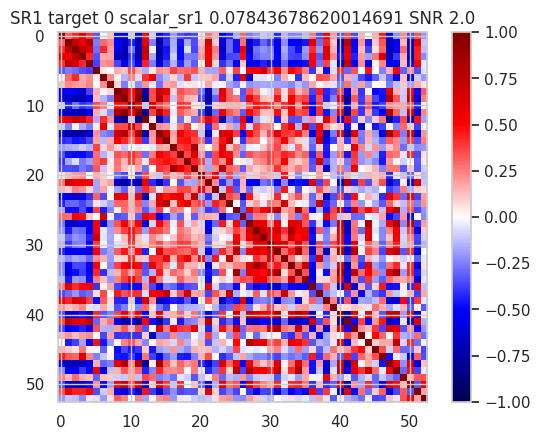

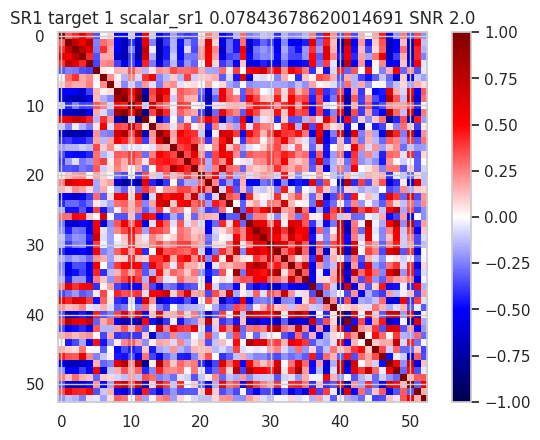

In [51]:
fnc_triu = sr1_df.iloc[0]['SR1_Window']
fncmat1 = np.zeros((53,53))
fncmat1[np.triu_indices(53)] = fnc_triu
fncmat1 = fncmat1 + fncmat1.T - np.diag(np.diag(fncmat1))
plt.imshow(fncmat1, cmap=plt.get_cmap('seismic'), vmin=-1, vmax=1)
plt.colorbar()
target = sr1_df.iloc[0]['target']
plt.title(f'SR1 target {target} scalar_sr1 {scalar_sr1} SNR {SNR}')
plt.show()

plt.clf()


fnc_triu = sr1_df.iloc[1]['SR1_Window']
fncmat2 = np.zeros((53,53))
fncmat2[np.triu_indices(53)] = fnc_triu
fncmat2 = fncmat2 + fncmat2.T - np.diag(np.diag(fncmat2))
plt.imshow(fncmat2, cmap=plt.get_cmap('seismic'), vmin=-1, vmax=1)
plt.colorbar()
target = sr1_df.iloc[1]['target']
plt.title(f'SR1 target {target} scalar_sr1 {scalar_sr1} SNR {SNR}')
plt.show()

diff2 = fncmat1 - fncmat2



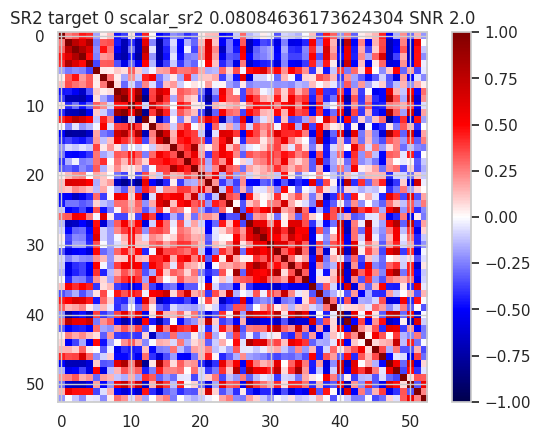

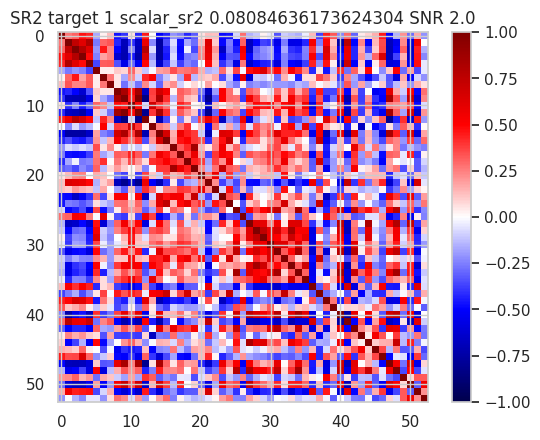

In [52]:
fnc_triu = sr2_df.iloc[0]['SR2_Window']
fncmat1 = np.zeros((53,53))
fncmat1[np.triu_indices(53)] = fnc_triu
fncmat1 = fncmat1 + fncmat1.T - np.diag(np.diag(fncmat1))
plt.imshow(fncmat1, cmap=plt.get_cmap('seismic'), vmin=-1, vmax=1)
plt.colorbar()
target = sr2_df.iloc[0]['target']
plt.title(f'SR2 target {target} scalar_sr2 {scalar_sr2} SNR {SNR}')
plt.show()

plt.clf()

fnc_triu = sr2_df.iloc[1]['SR2_Window']
fncmat2 = np.zeros((53,53))
fncmat2[np.triu_indices(53)] = fnc_triu
fncmat2 = fncmat2 + fncmat2.T - np.diag(np.diag(fncmat2))
plt.imshow(fncmat2, cmap=plt.get_cmap('seismic'), vmin=-1, vmax=1)
plt.colorbar()
target = sr2_df.iloc[1]['target']
plt.title(f'SR2 target {target} scalar_sr2 {scalar_sr2} SNR {SNR}')
plt.show()

diff1 = fncmat1 - fncmat2

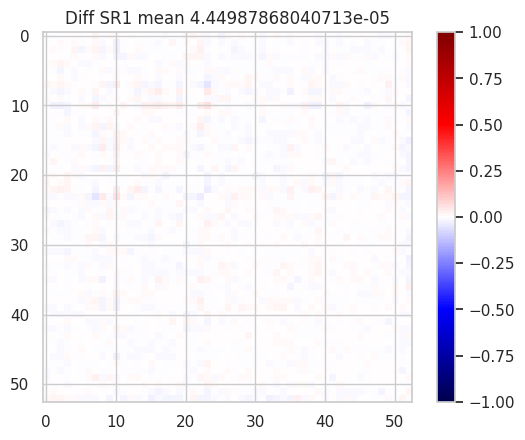

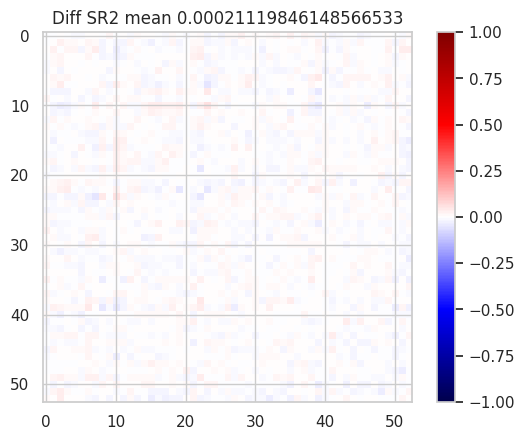

In [53]:
plt.clf()
plt.imshow(diff2, cmap=plt.get_cmap('seismic'), vmin=-1, vmax=1)
plt.colorbar()
plt.title(f'Diff SR1 mean {np.mean(diff2)}')
plt.show()


plt.clf()
plt.imshow(diff1, cmap=plt.get_cmap('seismic'), vmin=-1, vmax=1)
plt.colorbar()
plt.title(f'Diff SR2 mean {np.mean(diff1)}')
plt.show()

2024-05-10 01:42:25,011 - INFO - 



 START POLYSSIFIER FOR SR1 snr 2.0 noise_ix 0
2024-05-10 01:42:25,047 - INFO - Detected 2 classes in label
2024-05-10 01:42:25,048 - INFO - Building classifiers ...
2024-05-10 01:42:25,055 - INFO - Initialization, done.
2024-05-10 01:42:25,056 - INFO - Detected 10 unique groups


{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


2024-05-10 01:42:26,853 - INFO - Group Train: {1, 2, 3, 5, 6, 7, 8}
2024-05-10 01:42:26,857 - INFO - Training Multilayer Perceptron 0
2024-05-10 01:42:27,030 - INFO - Group Train: {0, 2, 3, 4, 6, 7, 8, 9}
2024-05-10 01:42:27,041 - INFO - Training Multilayer Perceptron 1
2024-05-10 01:42:27,447 - INFO - Group Train: {1, 2, 3, 5, 6, 7, 8}
2024-05-10 01:42:27,466 - INFO - Training SVM 0
2024-05-10 01:42:28,253 - INFO - Group Train: {0, 1, 3, 4, 5, 7, 9}
2024-05-10 01:42:28,266 - INFO - Training Multilayer Perceptron 2
2024-05-10 01:42:28,677 - INFO - Group Train: {0, 1, 3, 4, 5, 7, 9}
2024-05-10 01:42:28,697 - INFO - Training SVM 2
2024-05-10 01:42:28,676 - INFO - Group Train: {0, 1, 2, 4, 5, 6, 8, 9}
2024-05-10 01:42:28,717 - INFO - Training Multilayer Perceptron 3
2024-05-10 01:42:28,847 - INFO - Group Train: {1, 2, 3, 5, 6, 7, 8}
2024-05-10 01:42:28,870 - INFO - Training Logistic Regression 0
2024-05-10 01:42:29,147 - INFO - Group Train: {0, 2, 3, 4, 6, 7, 8, 9}
2024-05-10 01:42:29,220

                                 mean       std       min       max
Multilayer Perceptron train  1.000000  0.000000  1.000000  1.000000
                      test   0.580682  0.034986  0.535156  0.619740
SVM                   train  0.558340  0.244441  0.244024  0.772726
                      test   0.503185  0.033547  0.461493  0.543242
Logistic Regression   train  1.000000  0.000000  1.000000  1.000000
                      test   0.573018  0.034583  0.527188  0.610078
Naive Bayes           train  0.572951  0.004691  0.569236  0.579716
                      test   0.557988  0.017999  0.541285  0.577539
Voting                train  0.939509  0.009109  0.925893  0.944643
                      test   0.527344  0.030764  0.500000  0.562500


,graph_no,nstd,burnin,noise_no,snr,classifier,test_scores,target,predictions,test_proba
0,1002,1.0,100,0,2.0,Logistic Regression,0 0.57125 1 0.610078 2 0.527188 3 ...,"[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0 0.990632 1 0.994661 2 0.99...
1,1002,1.0,100,0,2.0,Multilayer Perceptron,0 0.61974 1 0.57877 2 0.535156 3 ...,"[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0 9.777136e-01 1 9.901254e-01 2 ...
2,1002,1.0,100,0,2.0,Naive Bayes,0 0.544184 1 0.577539 2 0.541285 3 ...,"[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0 9.573361e-13 1 2.406240e-12 2 ...
3,1002,1.0,100,0,2.0,SVM,0 0.461493 1 0.5 2 0.508003 3 ...,"[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0 0.481159 1 0.480930 2 0.48...


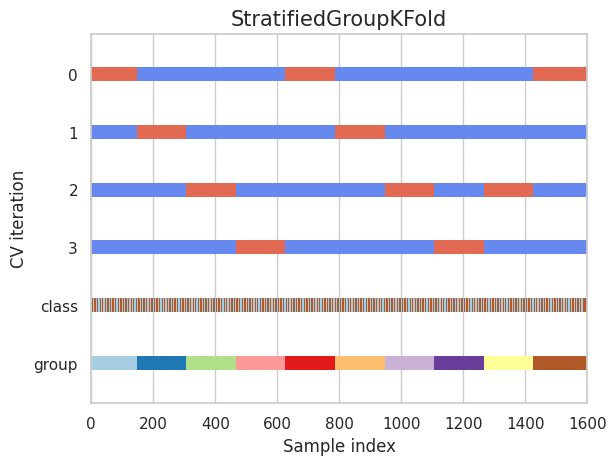

In [54]:
#############################
#   SR1
#############################
logging.info(f'\n\n\n\n START POLYSSIFIER FOR SR1 snr {SNR} noise_ix {noise_ix}')
group_sr1 = sr1_df['subject']
y_sr1 = sr1_df['target']
y_sr1 = np.array([str(entry) for entry in y_sr1])
X_sr1 = sr1_df['SR1_Window']
X_sr1 = np.array([np.array(entry) for entry in X_sr1])

res1 = []
report1 = poly(data=X_sr1, label=y_sr1, groups=group_sr1, n_folds=n_folds, scale=True, concurrency=n_threads, save=False, 
                exclude=['Decision Tree', 'Random Forest', 'Voting', 'Nearest Neighbors', 'Linear SVM'],  scoring='auc')

for classifier in report1.scores.columns.levels[0]:
            if classifier == 'Voting':
                continue

            res1.append({'graph_no': graph_ix,
                            'nstd': nstd,
                            'burnin': burn,
                            'noise_no': noise_ix,
                            'snr': SNR,
                            'classifier': classifier,
                            'test_scores': report1.scores[classifier, 'test'], 
                            'target': report1.target, 
                            'predictions': np.array(report1.predictions[classifier]).astype(int),
                            'test_proba': report1.test_proba[classifier]})

            logging.info(report1.scores[classifier, 'test'])

df1 = pd.DataFrame(res1)  

df1.to_pickle(f'/data/users2/jwardell1/undersampling-project/HCP/pkl-files/sr1_{SNR}_{graph_ix}.pkl')      # write SR1 dataframe to disk as pickle

df1

2024-05-10 01:46:22,778 - INFO - 



 START POLYSSIFIER FOR SR2 snr 2.0 noise_ix 0
2024-05-10 01:46:22,803 - INFO - Detected 2 classes in label
2024-05-10 01:46:22,804 - INFO - Building classifiers ...
2024-05-10 01:46:22,811 - INFO - Initialization, done.
2024-05-10 01:46:22,813 - INFO - Detected 10 unique groups


{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


2024-05-10 01:46:24,706 - INFO - Group Train: {0, 2, 3, 4, 6, 7, 8, 9}
2024-05-10 01:46:24,711 - INFO - Training Multilayer Perceptron 1
2024-05-10 01:46:25,175 - INFO - Group Train: {0, 1, 3, 4, 5, 7, 9}
2024-05-10 01:46:25,183 - INFO - Training Multilayer Perceptron 2
2024-05-10 01:46:25,189 - INFO - Group Train: {1, 2, 3, 5, 6, 7, 8}
2024-05-10 01:46:25,215 - INFO - Training SVM 0
2024-05-10 01:46:25,372 - INFO - Group Train: {1, 2, 3, 5, 6, 7, 8}
2024-05-10 01:46:25,394 - INFO - Training Multilayer Perceptron 0
2024-05-10 01:46:25,838 - INFO - Group Train: {0, 1, 2, 4, 5, 6, 8, 9}
2024-05-10 01:46:25,872 - INFO - Training SVM 3
2024-05-10 01:46:26,047 - INFO - Group Train: {0, 1, 3, 4, 5, 7, 9}
2024-05-10 01:46:26,069 - INFO - Training SVM 2
2024-05-10 01:46:26,487 - INFO - Group Train: {0, 2, 3, 4, 6, 7, 8, 9}
2024-05-10 01:46:26,516 - INFO - Training SVM 1
2024-05-10 01:46:26,729 - INFO - Group Train: {0, 2, 3, 4, 6, 7, 8, 9}
2024-05-10 01:46:26,772 - INFO - Group Train: {0, 1, 3

                                 mean       std       min       max
Multilayer Perceptron train  1.000000  0.000000  1.000000  1.000000
                      test   0.567973  0.045144  0.532500  0.633047
SVM                   train  0.894919  0.037314  0.844504  0.934361
                      test   0.559660  0.023080  0.540486  0.591191
Logistic Regression   train  0.995051  0.009898  0.980204  1.000000
                      test   0.565655  0.041507  0.538715  0.627187
Naive Bayes           train  0.629082  0.030114  0.610073  0.673597
                      test   0.543352  0.010391  0.528854  0.551133
Voting                train  0.902790  0.061474  0.859375  0.993750
                      test   0.509375  0.008757  0.500000  0.518750


,graph_no,nstd,burnin,noise_no,snr,classifier,test_scores,target,predictions,test_proba
0,1002,1.0,100,0,2.0,Logistic Regression,0 0.538715 1 0.627187 2 0.542969 3 ...,"[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, ...",0 0.434267 1 0.448646 2 0.46...
1,1002,1.0,100,0,2.0,Multilayer Perceptron,0 0.543611 1 0.633047 2 0.5325 3 ...,"[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0 1.201076e-06 1 2.212240e-06 2 ...
2,1002,1.0,100,0,2.0,Naive Bayes,0 0.542795 1 0.550625 2 0.528854 3 ...,"[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0 8.210575e-13 1 1.763007e-12 2 ...
3,1002,1.0,100,0,2.0,SVM,0 0.54454 1 0.591191 2 0.540486 3 ...,"[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0 0.328355 1 0.331025 2 0.33...


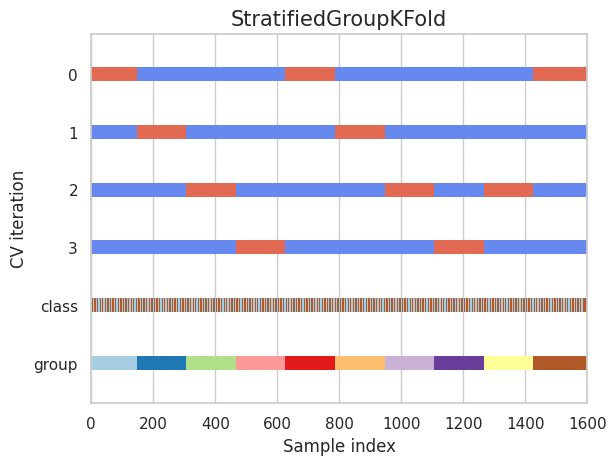

In [55]:
#############################
#   SR2
#############################
logging.info(f'\n\n\n\n START POLYSSIFIER FOR SR2 snr {SNR} noise_ix {noise_ix}')
group_sr2 = sr2_df['subject']
y_sr2 = sr2_df['target']
y_sr2 = np.array([str(entry) for entry in y_sr2])
X_sr2 = sr2_df['SR2_Window']
X_sr2 = np.array([np.array(entry) for entry in X_sr2])

res2 = []
report2 = poly(data=X_sr2, label=y_sr2, groups=group_sr2, n_folds=n_folds, scale=True, concurrency=n_threads, save=False, 
                exclude=['Decision Tree', 'Random Forest', 'Voting', 'Nearest Neighbors', 'Linear SVM'],  scoring='auc')

for classifier in report2.scores.columns.levels[0]:                                                                                         # iterate through all classifiers in the report
            if classifier == 'Voting':
                continue

            res2.append({'graph_no': graph_ix,                                                                                                      # save the SR1 results to a dict for results dataframe
                            'nstd': nstd,
                            'burnin': burn,
                            'noise_no': noise_ix,
                            'snr': SNR,
                            'classifier': classifier,
                            'test_scores': report2.scores[classifier, 'test'], 
                            'target': report2.target, 
                            'predictions': np.array(report2.predictions[classifier]).astype(int),
                            'test_proba': report2.test_proba[classifier]})

            logging.info(report2.scores[classifier, 'test'])


df2 = pd.DataFrame(res2)

df2.to_pickle(f'/data/users2/jwardell1/undersampling-project/HCP/pkl-files/sr2_{SNR}_{graph_ix}.pkl')      # write SR2 dataframe to disk as pickle

df2



2024-05-10 01:49:53,420 - INFO - 



 START POLYSSIFIER FOR CONCAT snr 2.0 noise_ix 0
2024-05-10 01:49:53,467 - INFO - Detected 2 classes in label
2024-05-10 01:49:53,468 - INFO - Building classifiers ...
2024-05-10 01:49:53,474 - INFO - Initialization, done.
2024-05-10 01:49:53,476 - INFO - Detected 10 unique groups


{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


2024-05-10 01:49:55,693 - INFO - Group Train: {0, 1, 3, 4, 5, 7, 9}
2024-05-10 01:49:55,699 - INFO - Training Multilayer Perceptron 2
2024-05-10 01:49:56,484 - INFO - Group Train: {1, 2, 3, 5, 6, 7, 8}
2024-05-10 01:49:56,515 - INFO - Training Multilayer Perceptron 0
2024-05-10 01:49:58,073 - INFO - Group Train: {0, 2, 3, 4, 6, 7, 8, 9}
2024-05-10 01:49:58,106 - INFO - Training SVM 1
2024-05-10 01:49:58,117 - INFO - Group Train: {1, 2, 3, 5, 6, 7, 8}
2024-05-10 01:49:58,117 - INFO - Group Train: {0, 1, 2, 4, 5, 6, 8, 9}
2024-05-10 01:49:58,151 - INFO - Training Multilayer Perceptron 3
2024-05-10 01:49:58,139 - INFO - Training SVM 0
2024-05-10 01:49:58,210 - INFO - Group Train: {0, 1, 3, 4, 5, 7, 9}
2024-05-10 01:49:58,223 - INFO - Training SVM 2
2024-05-10 01:49:58,213 - INFO - Group Train: {0, 2, 3, 4, 6, 7, 8, 9}
2024-05-10 01:49:58,236 - INFO - Training Multilayer Perceptron 1
2024-05-10 01:49:58,890 - INFO - Group Train: {0, 1, 2, 4, 5, 6, 8, 9}
2024-05-10 01:49:58,916 - INFO - Tra

                                 mean       std       min       max
Multilayer Perceptron train  1.000000  0.000000  1.000000  1.000000
                      test   0.570455  0.027714  0.542101  0.602344
SVM                   train  0.823413  0.028286  0.785165  0.853364
                      test   0.550531  0.023862  0.526997  0.582227
Logistic Regression   train  0.991741  0.010169  0.979158  1.000000
                      test   0.566226  0.037927  0.537118  0.621445
Naive Bayes           train  0.600764  0.014478  0.591481  0.622082
                      test   0.550398  0.012744  0.534913  0.561172
Voting                train  0.893080  0.057454  0.821875  0.944643
                      test   0.508073  0.008174  0.500000  0.515625


,graph_no,nstd,burnin,noise_no,snr,classifier,test_scores,target,predictions,test_proba
0,1002,1.0,100,0,2.0,Logistic Regression,0 0.546927 1 0.621445 2 0.537118 3 ...,"[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, ...","[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0 0.472283 1 0.493089 2 0.51...
1,1002,1.0,100,0,2.0,Multilayer Perceptron,0 0.584132 1 0.602344 2 0.542101 3 ...,"[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, ...",0 0.000155 1 0.000529 2 0.00...
2,1002,1.0,100,0,2.0,Naive Bayes,0 0.545 1 0.561172 2 0.534913 3 ...,"[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0 7.860281e-25 1 4.242219e-24 2 ...
3,1002,1.0,100,0,2.0,SVM,0 0.526997 1 0.582227 2 0.538819 3 ...,"[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0 0.586896 1 0.588603 2 0.58...


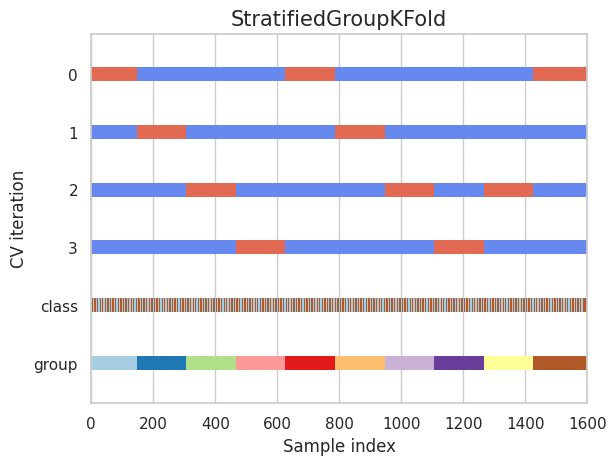

In [56]:

#############################
#   CONCAT
#############################
logging.info(f'\n\n\n\n START POLYSSIFIER FOR CONCAT snr {SNR} noise_ix {noise_ix}')
group_concat = concat_df['subject']
y_concat = concat_df['target']
y_concat = np.array([str(entry) for entry in y_concat])
X_concat = concat_df['Concat_Window']
X_concat = np.array([np.array(entry) for entry in X_concat])

res3 = []
report3 = poly(data=X_concat, label=y_concat, groups=group_concat, n_folds=n_folds, scale=True, concurrency=n_threads, save=False, 
                exclude=['Decision Tree', 'Random Forest', 'Voting', 'Nearest Neighbors', 'Linear SVM'],  scoring='auc')

for classifier in report3.scores.columns.levels[0]:                                                                                         # iterate through all classifiers in the report
            if classifier == 'Voting':
                continue

            res3.append({'graph_no': graph_ix,                                                                                                      # save the SR1 results to a dict for results dataframe
                            'nstd': nstd,
                            'burnin': burn,
                            'noise_no': noise_ix,
                            'snr': SNR,
                            'classifier': classifier,
                            'test_scores': report3.scores[classifier, 'test'], 
                            'target': report3.target, 
                            'predictions': np.array(report3.predictions[classifier]).astype(int),
                            'test_proba': report3.test_proba[classifier]})

            logging.info(report3.scores[classifier, 'test'])


df3 = pd.DataFrame(res3)                                                                                    # save CONCAT results as dataframe

df3.to_pickle(f'/data/users2/jwardell1/undersampling-project/HCP/pkl-files/concat_{SNR}_{graph_ix}.pkl')   # write CONCAT dataframe to disk as pickle

df3



2024-05-10 01:57:12,163 - INFO - 



 START POLYSSIFIER FOR ADD snr 2.0 noise_ix 0
2024-05-10 01:57:12,191 - INFO - Detected 2 classes in label
2024-05-10 01:57:12,193 - INFO - Building classifiers ...
2024-05-10 01:57:12,199 - INFO - Initialization, done.
2024-05-10 01:57:12,201 - INFO - Detected 10 unique groups


{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


2024-05-10 01:57:13,857 - INFO - Group Train: {1, 2, 3, 5, 6, 7, 8}
2024-05-10 01:57:13,861 - INFO - Training SVM 0
2024-05-10 01:57:14,073 - INFO - Group Train: {0, 1, 3, 4, 5, 7, 9}
2024-05-10 01:57:14,077 - INFO - Training Multilayer Perceptron 2
2024-05-10 01:57:14,155 - INFO - Group Train: {0, 2, 3, 4, 6, 7, 8, 9}
2024-05-10 01:57:14,183 - INFO - Training Multilayer Perceptron 1
2024-05-10 01:57:14,237 - INFO - Group Train: {0, 1, 2, 4, 5, 6, 8, 9}
2024-05-10 01:57:14,253 - INFO - Training Multilayer Perceptron 3
2024-05-10 01:57:14,270 - INFO - Group Train: {0, 2, 3, 4, 6, 7, 8, 9}
2024-05-10 01:57:14,281 - INFO - Training SVM 1
2024-05-10 01:57:14,457 - INFO - Group Train: {1, 2, 3, 5, 6, 7, 8}
2024-05-10 01:57:14,510 - INFO - Training Multilayer Perceptron 0
2024-05-10 01:57:14,621 - INFO - Group Train: {0, 1, 3, 4, 5, 7, 9}
2024-05-10 01:57:14,640 - INFO - Training SVM 2
2024-05-10 01:57:14,749 - INFO - Group Train: {0, 1, 2, 4, 5, 6, 8, 9}
2024-05-10 01:57:14,764 - INFO - Tra

                                 mean       std       min       max
Multilayer Perceptron train  1.000000  0.000000  1.000000  1.000000
                      test   0.563420  0.027454  0.527049  0.592852
SVM                   train  0.805433  0.018466  0.787469  0.826266
                      test   0.541653  0.031258  0.505260  0.576250
Logistic Regression   train  0.969428  0.036981  0.925364  1.000000
                      test   0.566429  0.034252  0.535625  0.612734
Naive Bayes           train  0.587603  0.011376  0.580200  0.604506
                      test   0.549443  0.011290  0.535295  0.559648
Voting                train  0.922991  0.038719  0.889286  0.960156
                      test   0.506510  0.006717  0.500000  0.514583


,graph_no,nstd,burnin,noise_no,snr,classifier,test_scores,target,predictions,test_proba
0,1002,1.0,100,0,2.0,Logistic Regression,0 0.546302 1 0.612734 2 0.535625 3 ...,"[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, ...","[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0 0.480044 1 0.490912 2 0.50...
1,1002,1.0,100,0,2.0,Multilayer Perceptron,0 0.571788 1 0.592852 2 0.527049 3 ...,"[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0 0.002353 1 0.005297 2 0.00...
2,1002,1.0,100,0,2.0,Naive Bayes,0 0.545486 1 0.559648 2 0.535295 3 ...,"[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0 2.721951e-13 1 6.901262e-13 2 ...
3,1002,1.0,100,0,2.0,SVM,0 0.528264 1 0.556836 2 0.50526 3 ...,"[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0 0.547484 1 0.548323 2 0.54...


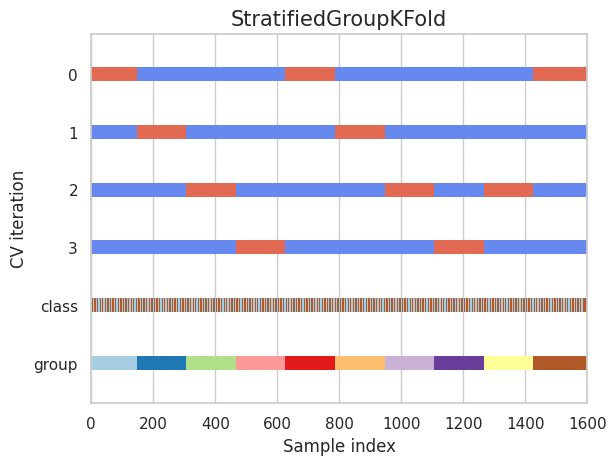

In [57]:
#############################
#   ADD
#############################
logging.info(f'\n\n\n\n START POLYSSIFIER FOR ADD snr {SNR} noise_ix {noise_ix}')
group_add = add_df['subject']
y_add = add_df['target']
y_add = np.array([str(entry) for entry in y_add])
X_add = add_df['Add_Window']
X_add = np.array([np.array(entry) for entry in X_add])

res4 = []
report4 = poly(data=X_add, label=y_add, groups=group_add, n_folds=n_folds, scale=True, concurrency=n_threads, save=False, 
                exclude=['Decision Tree', 'Random Forest', 'Voting', 'Nearest Neighbors', 'Linear SVM'],  scoring='auc')

for classifier in report4.scores.columns.levels[0]:                                                                                         # iterate through all classifiers in the report
            if classifier == 'Voting':
                continue

            res4.append({'graph_no': graph_ix,                                                                                                      # save the SR1 results to a dict for results dataframe
                            'nstd': nstd,
                            'burnin': burn,
                            'noise_no': noise_ix,
                            'snr': SNR,
                            'classifier': classifier,
                            'test_scores': report4.scores[classifier, 'test'], 
                            'target': report4.target, 
                            'predictions': np.array(report4.predictions[classifier]).astype(int),
                            'test_proba': report4.test_proba[classifier]})

            logging.info(report4.scores[classifier, 'test'])



df4 = pd.DataFrame(res4)                                                                                    # save ADD results as dataframe

df4.to_pickle(f'/data/users2/jwardell1/undersampling-project/HCP/pkl-files/add_{SNR}_{graph_ix}.pkl')      # write ADD dataframe to disk as pickle

df4

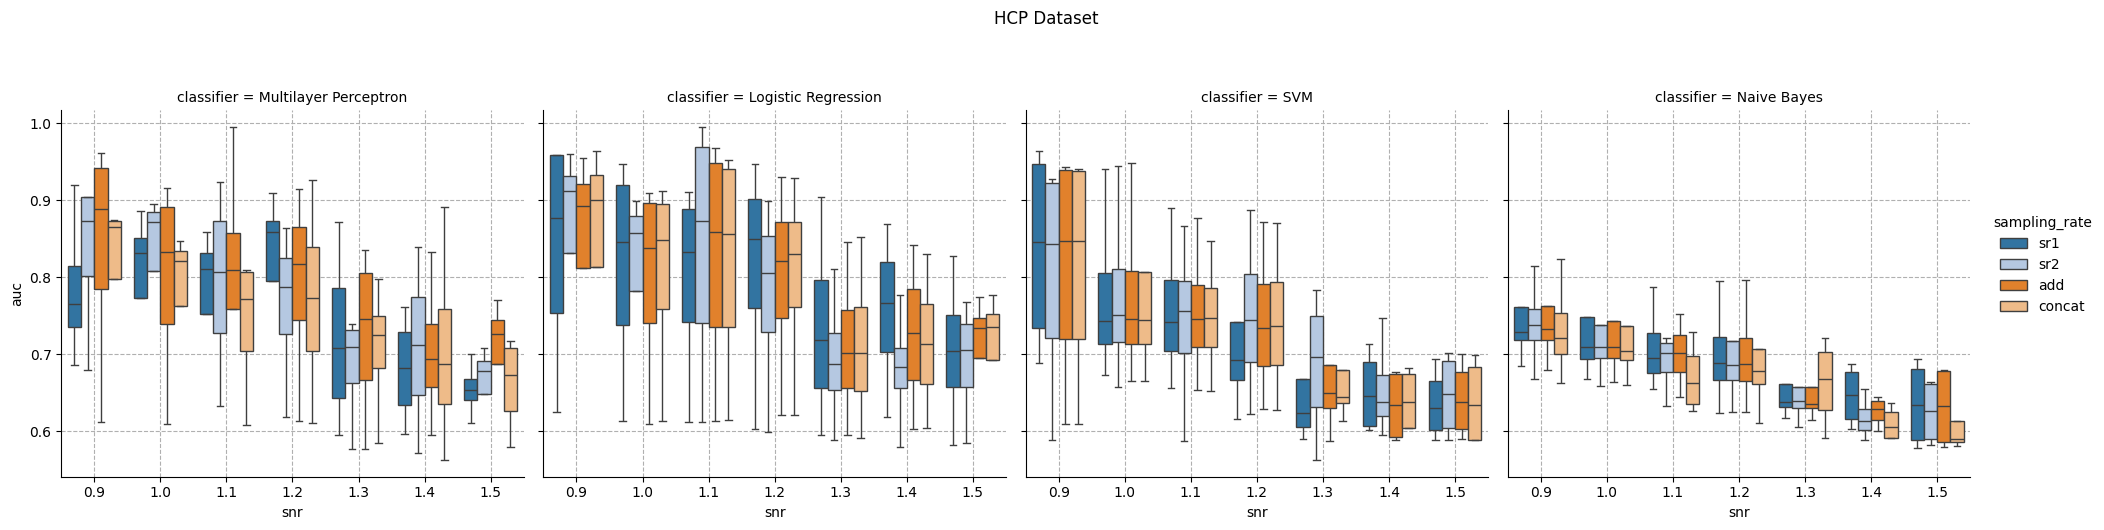

In [9]:
import pandas as pd
import os
import glob
import matplotlib.ticker as ticker # type: ignore
from statannot import add_stat_annotation


import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

import numpy as np
import os
from matplotlib.ticker import MaxNLocator

from sklearn.metrics import roc_curve, auc

import os
import glob
import pandas as pd

pkl_dir = '/data/users2/jwardell1/undersampling-project/HCP/pkl-files'

# Read and concatenate sr1 data
joined_files = os.path.join(pkl_dir, 'sr1_*.pkl')
joined_list = glob.glob(joined_files)
sr1 = pd.concat((pd.read_pickle(file).assign(sampling_rate='sr1') for file in joined_list), ignore_index=True)

# Read and concatenate sr2 data
joined_files = os.path.join(pkl_dir, 'sr2_*.pkl')
joined_list = glob.glob(joined_files)
sr2 = pd.concat((pd.read_pickle(file).assign(sampling_rate='sr2') for file in joined_list), ignore_index=True)

# Read and concatenate concat data
joined_files = os.path.join(pkl_dir, 'concat_*.pkl')
joined_list = glob.glob(joined_files)
concat = pd.concat((pd.read_pickle(file).assign(sampling_rate='concat') for file in joined_list), ignore_index=True)

# Read and concatenate add data
joined_files = os.path.join(pkl_dir, 'add_*.pkl')
joined_list = glob.glob(joined_files)
add = pd.concat((pd.read_pickle(file).assign(sampling_rate='add') for file in joined_list), ignore_index=True)

# Concatenate all dataframes
all_data = pd.concat([sr1, sr2, concat, add], ignore_index=True)

import pandas as pd

# Function to split each row into multiple rows based on cross-validation index
def split_row(row):
    new_rows = []
    for cv_ix, auc in enumerate(row['test_scores']):
        new_row = row.copy()
        new_row['auc'] = auc
        new_row['cv_ix'] = cv_ix
        new_rows.append(new_row)
    return pd.DataFrame(new_rows)

# Apply the split_row function to each row of the dataframe and concatenate the results
result_df = pd.concat(all_data.apply(split_row, axis=1).tolist(), ignore_index=True)



# Drop the original 'test_scores' column as it's no longer needed
result_df.drop('test_scores', axis=1, inplace=True)



grouped_classifiers = result_df.groupby('classifier')


classifier_dfs = {}
for classifier, group_df in grouped_classifiers:
    classifier_dfs[classifier] = group_df.copy()

mlp_df = classifier_dfs['Multilayer Perceptron']
lr_df = classifier_dfs['Logistic Regression']
svm_df = classifier_dfs['SVM']
nb_df = classifier_dfs['Naive Bayes']

import seaborn as sns
import matplotlib.pyplot as plt


dfs = [mlp_df, lr_df, svm_df, nb_df]
classifiers = ['Multilayer Perceptron', 'Logistic Regression', 'SVM', 'Naive Bayes']
sampling_rates = ['sr1', 'sr2', 'add', 'concat']
hue_order = sampling_rates
palette = { item: plt.cm.tab20(i) for i, item in enumerate(sampling_rates)}

# Combine all dataframes into one dataframe for plotting
combined_df = pd.concat(dfs)

#snr_levels = [0.5 , 0.6 , 0.7 , 0.8 , 0.9 , 1.0 , 1.1 , 1.2 , 1.3 , 1.4 , 1.5 , 1.6 , 1.7 , 1.8 , 1.9 , 2.0]
snr_levels = [ 0.9 , 1.0 , 1.1 , 1.2 , 1.3 , 1.4 , 1.5]






# Plot all boxplots in one plot using catplot
ax = sns.catplot(
    x="snr", 
    order=snr_levels,
    y="auc",
    hue="sampling_rate",
    hue_order=hue_order,
    col="classifier",
    data=combined_df,
    kind="box",
    palette=palette,
    showfliers=False
)
# Set the title of the main plot with some padding
ax.fig.suptitle("HCP Dataset", y=1.05)

# Adjust the spacing between the main title and the columns
plt.subplots_adjust(top=0.85)
for axes in ax.axes.flat:
    axes.grid(True, which='both', axis='both', linestyle='--')

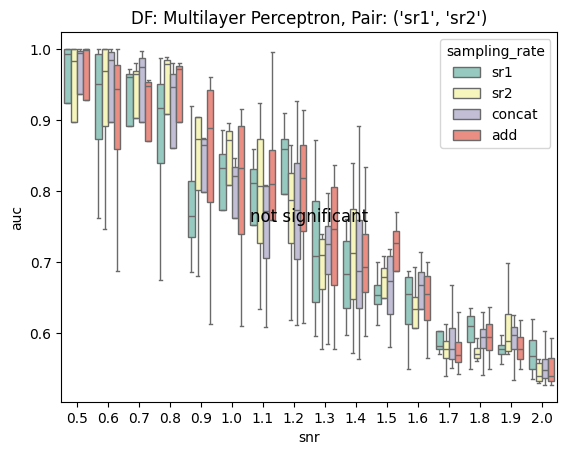

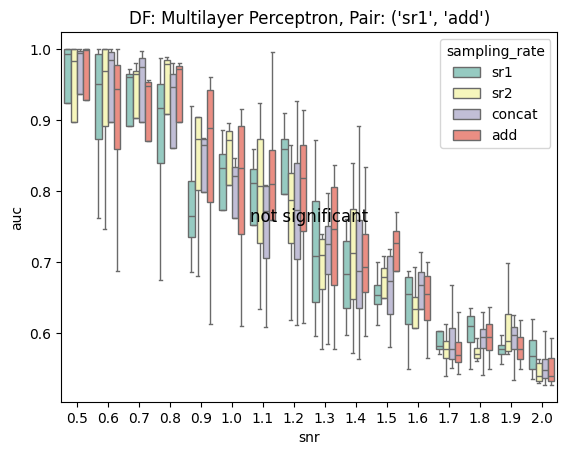

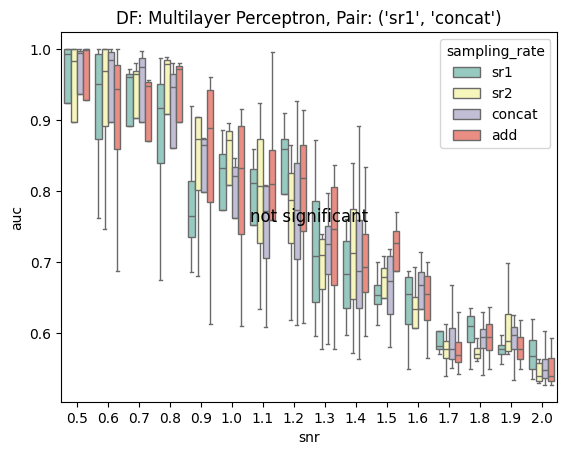

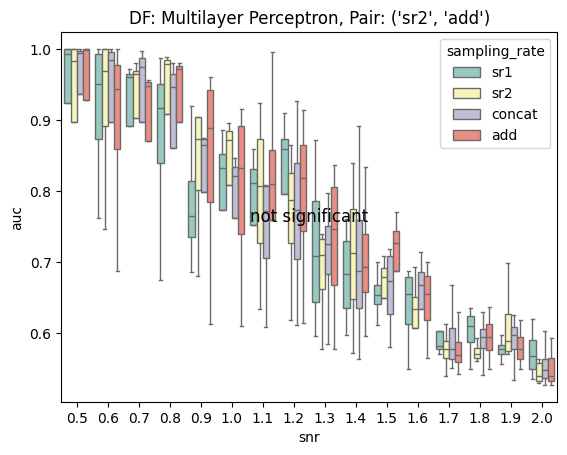

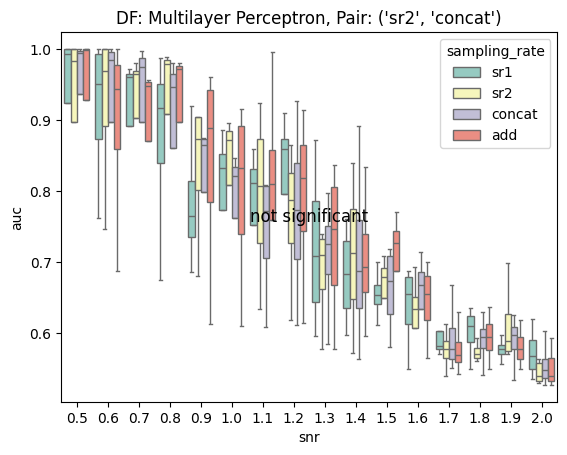

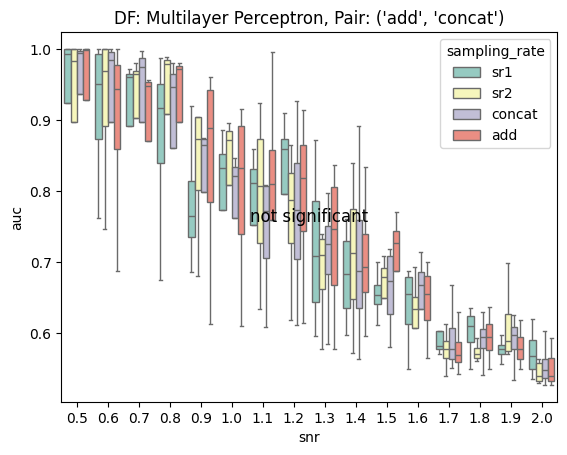

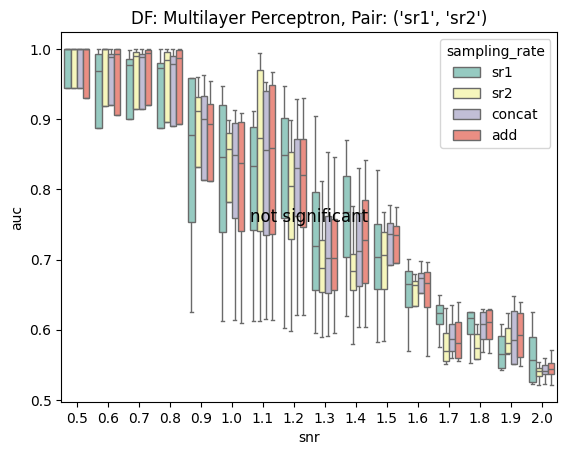

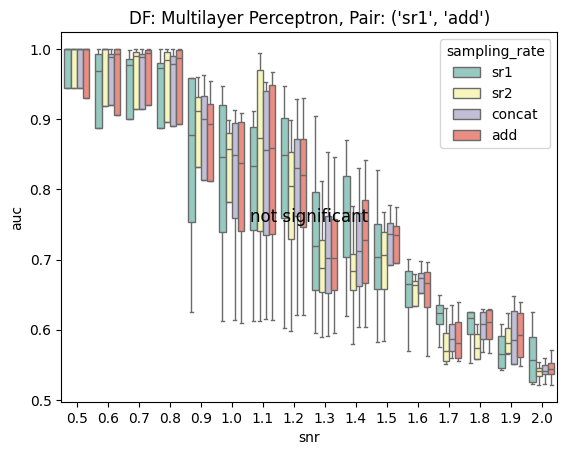

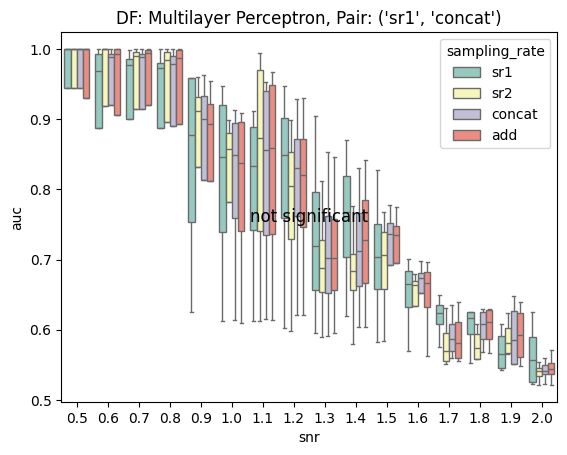

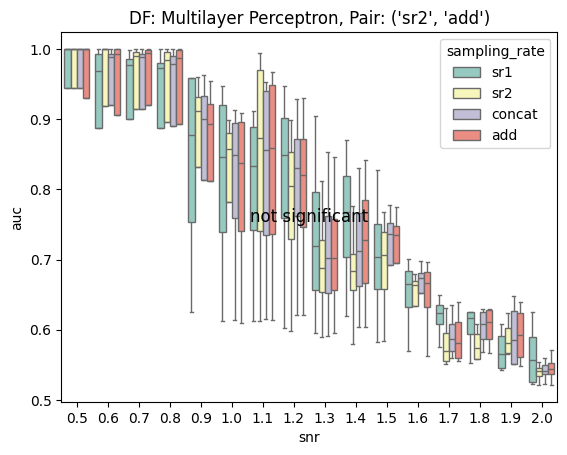

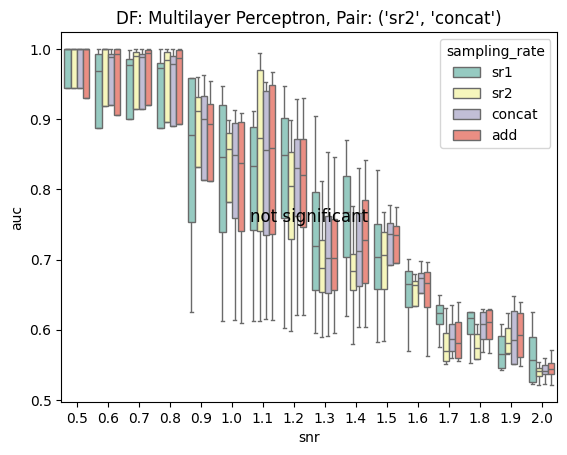

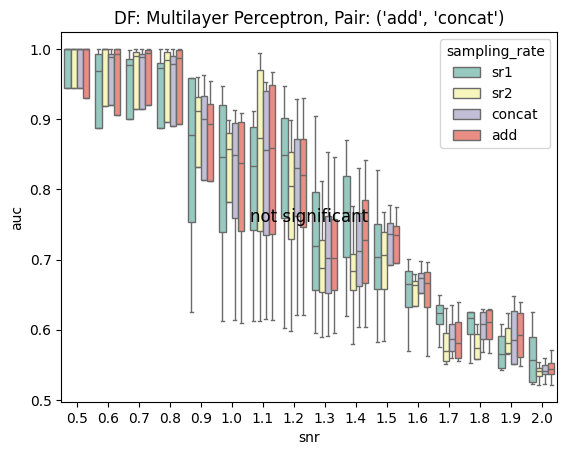

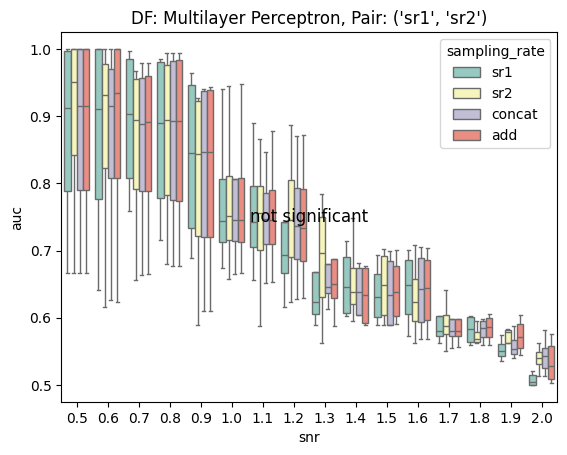

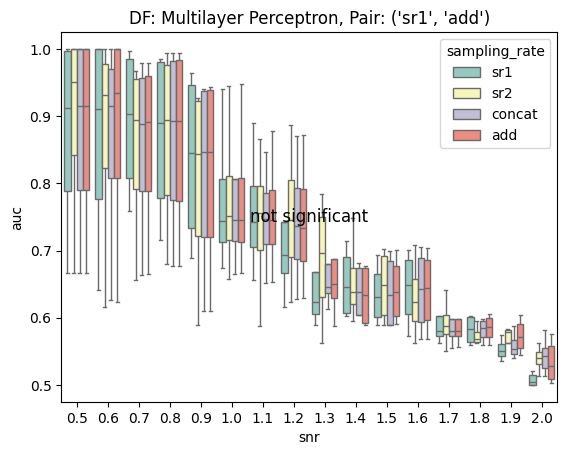

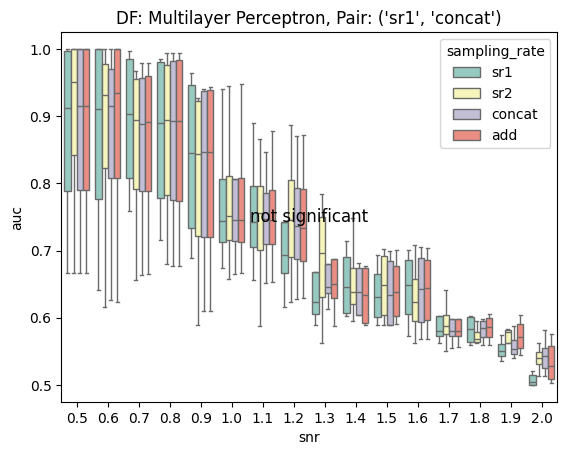

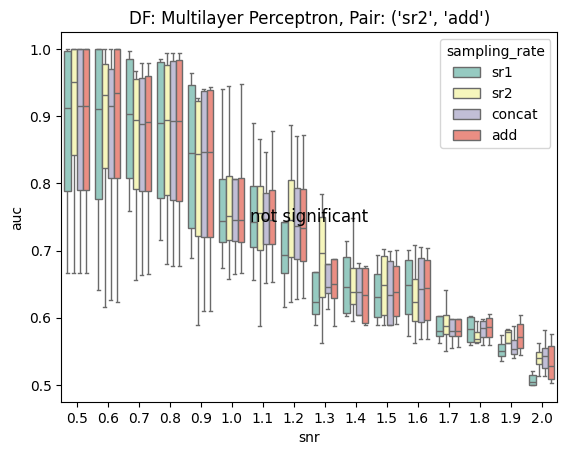

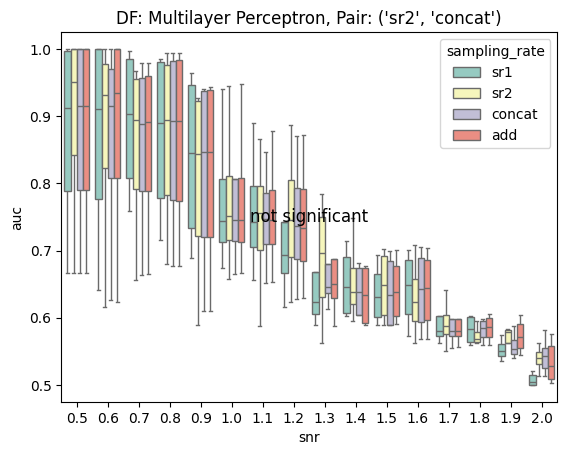

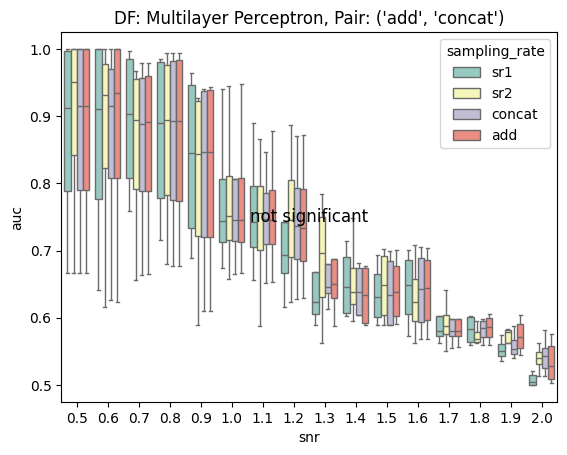

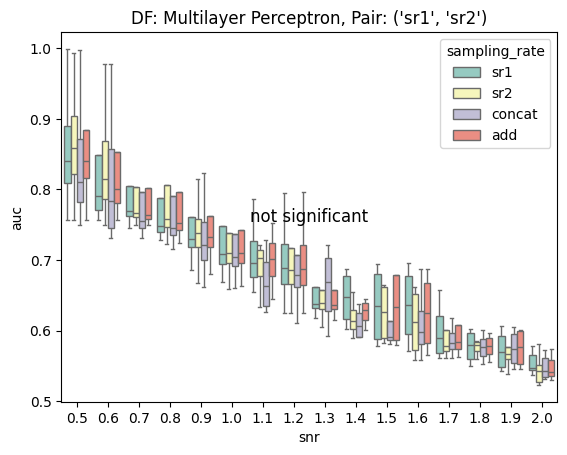

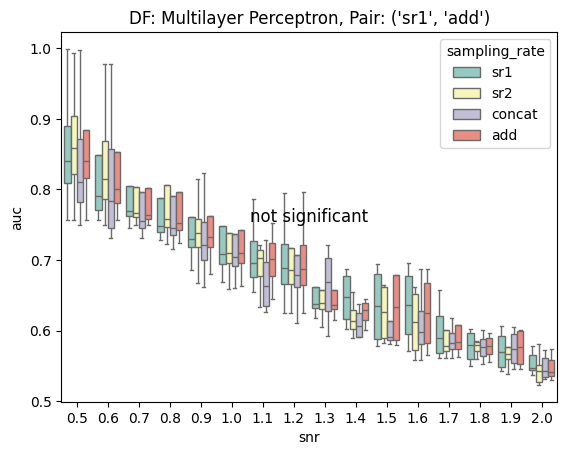

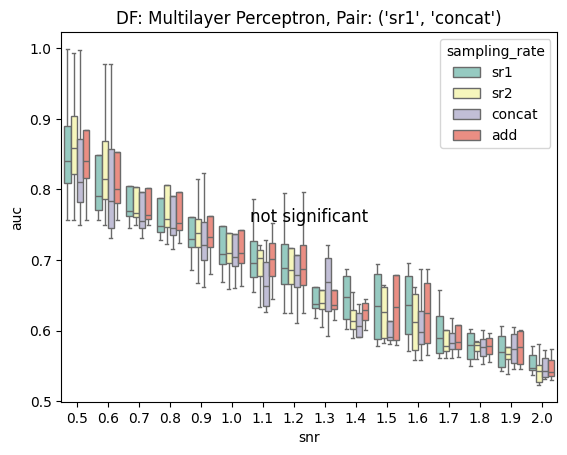

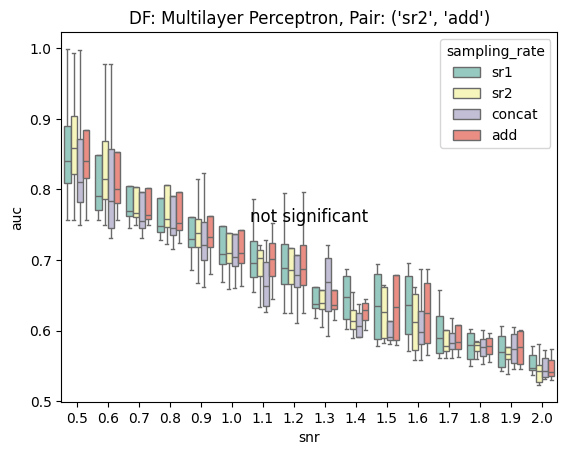

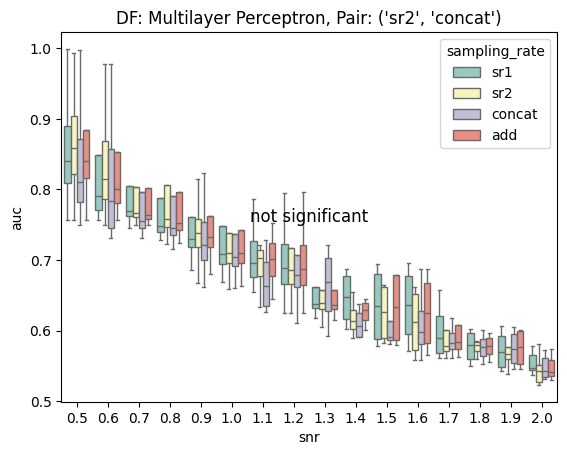

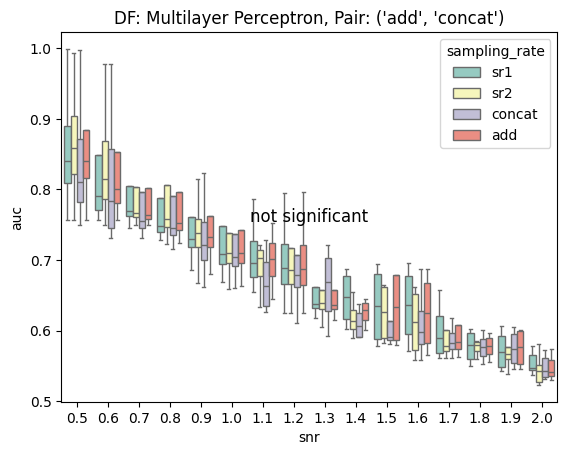

In [5]:
from itertools import combinations
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Define all sampling rates
sampling_rates = ['sr1', 'sr2', 'add', 'concat']
dfs = [mlp_df, lr_df, svm_df, nb_df]
df_name = ['Multilayer Perceptron', 'Logistic Regression', 'SVM', 'Naive Bayes']
# Get all possible combinations of pairs
pairs = list(combinations(sampling_rates, 2))



# Iterate over all dataframes
for df in dfs:
    ix = 0
    # Filter the dataframe for snr values in the range [1.5, 2]
    filtered_df = df[df["snr"].astype(float).between(0.5, 2)]
    
    # Define the p-value annotation legend
    pvalue_legend = {'ns': '5.00e-02 < p <= 1.00e+00',
                     '*': '1.00e-02 < p <= 5.00e-02',
                     '**': '1.00e-03 < p <= 1.00e-02',
                     '***': '1.00e-04 < p <= 1.00e-03',
                     '****': 'p <= 1.00e-04'}

    # Perform t-test and annotate the plot for each pair
    for pair in pairs:
        # Filter the dataframe for the two sampling rates
        filtered_df1 = filtered_df[filtered_df["sampling_rate"] == pair[0]]
        filtered_df2 = filtered_df[filtered_df["sampling_rate"] == pair[1]]
        # Perform t-test and get p-value
        t_statistic, p_value = stats.ttest_ind(filtered_df1["auc"], filtered_df2["auc"])
        # Get the corresponding annotation or set it to "not significant" if not found
        pvalue_annotation = pvalue_legend.get(p_value, "not significant")

        # Plot the boxplot
        sns.boxplot(x="snr", y="auc", hue="sampling_rate", data=filtered_df, palette="Set3", showfliers=False)
        # Annotate the plot with p-value
        plt.text(0.5, 0.5, pvalue_annotation, fontsize=12, ha='center', va='center', transform=plt.gca().transAxes)
        plt.title(f'DF: {df_name[ix]}, Pair: {pair}')
        # Show the plot
        plt.show()
    ix += 1


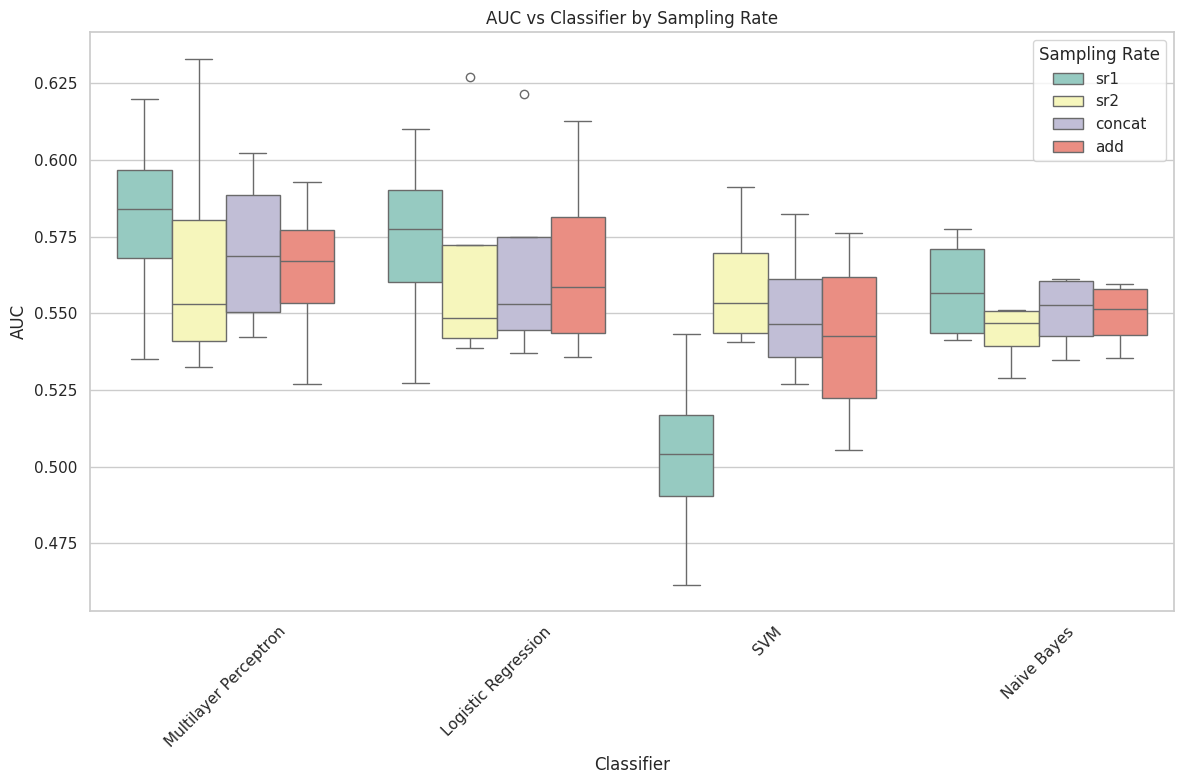

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set seaborn style
sns.set(style="whitegrid")

# Plot boxplots for each sampling rate within each classifier
plt.figure(figsize=(12, 8))
sns.boxplot(x="classifier", y="auc", hue="sampling_rate", data=combined_df, palette="Set3", showfliers=True)

# Set labels and title
plt.xlabel("Classifier")
plt.ylabel("AUC")
plt.title("AUC vs Classifier by Sampling Rate")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.legend(title="Sampling Rate")
plt.show()
